# Indirect optimal control of nondimensional inverted pendulum via Pontryagin's minimum principle

In [57]:
from sympy import *
import numpy as np
from scipy.optimize import newton, fsolve
import matplotlib.pyplot as plt
init_printing()

# State variables

In [58]:
x, v, theta, omega = symbols("x v \\theta, \\omega")
s = Matrix([x, v, theta, omega])
s.T

## Control variable

In [59]:
u, us = symbols("u \overline{u}")
u, us

## State equations of motion

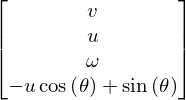

In [60]:
ds = Matrix([v, u, omega, sin(theta) - u*cos(theta)])
ds

## Homotopic Lagrangian

In [61]:
alpha = symbols("alpha")
L = (1-alpha)*u**2 + alpha*1
L

## Costate variables

In [62]:
l = Matrix([symbols("\\lambda_{}".format(var)) for var in s])
l.T

## Hamiltonian

In [63]:
H = L + l.dot(ds)
H

## Costate equations of motion

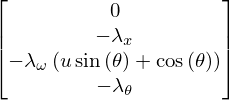

In [64]:
dl = -H.diff(s)
dl

## Energy optimal control $\alpha \in [0,1)$

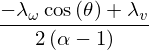

In [65]:
uo = solve(H.diff(u), u)[0]
uo

## Time optimal control $\alpha = 1$

In [66]:
uto = sign(limit(uo, alpha, 1))*us
uto

## Energy

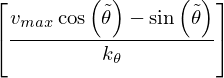

In [67]:
vm, tt, tr, kt = symbols("v_{max} \\tilde{\\theta} \\theta_r k_\\theta")
expr = kt*(tt-tr) + sin(tt) - vm*cos(tt)
solve(expr.subs(tr, 0), tt, implicit=True)

In [68]:
def ec_tt(tt, tr, kx, kv, kt, kw, um):
    xm = np.pi**2*(np.pi+um)
    vm = np.pi*um
    res = kt*(tt-tr) + np.sin(tt) - vm*np.cos(tt)
    res += kt*np.arctan(kx*xm + kv*vm)
    return res

-5.995673421238132
0.2875118859414538
6.57069719312104


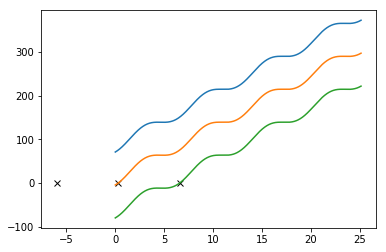

In [86]:
fig, ax = plt.subplots(1)
tt = np.linspace(0, 8*np.pi, 1000)
for tr in [-2*np.pi, 0, 2*np.pi]:
    fun = lambda tt: ec_tt(tt, tr, 0.01, 0.01, 12, 1, 4)
    res = newton(fun, np.pi)
    print(res)
    ax.plot(res, fun(res), "kx")
    ax.plot(tt, fun(tt))

In [43]:
tr, kx, kv, kt, kw, um = symbols('\\theta_r k_x k_v k_\\theta k_\\omega u_m')
tt = symbols("\\tilde{\\theta}", positive=True)

In [44]:
xm = pi**2*(pi+um)
vm = pi*um
res = kt*(tt-tr) + sin(tt) - vm*cos(tt)
res += kt*atan(kx*xm + kv*vm)

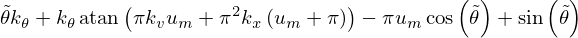

In [46]:
res.subs(tr,0)